# Finding an Optmial Marketing Budget with Vector AutoRegression and Impulse Response Analysis

Marketing budget allocation for a medium-sized retailer by Jaume Clave  
April 17th, 2020

The 2019 global advertisement budget surpassed $560 billion USD, the US and North-American market being the largest spenders[2]. These budgets are stretched among various channels as internet advertising now not only relates to “traditional” Google Ads spending or Facebook Ads spending but to influencer marketing on quickly growing social media apps like Tik-Tok and Snapchat. Not surprisingly print media is seeing negative growth in investments and is expected to do so in the foreseeable future. As new marketing opportunities arise not only do decision makers need to figure out how much company resource to devote to their marketing campaigns, they need to decide where exactly to spend that budget. 

This paper contains a detailed analytical investigation into a retailers marketing budget and it provides an improvement to it by finding its optimal channel allocation. The examination is completed to help the retailer better use their annual marketing budget in order to increase audience reach, conversions and ultimately sales that lead to bottom-line growth.

## Index 

[The Dataset](#The-Dataset)  
i. [Visualising the Time Series](#Visualising-the-Time-Series)  

[Vector AutoRegression (VAR)](#Vector-AutoRegression-(VAR))  
i. [Testing Causation using Granger’s Causality Test](#Testing-Causation-using-Granger’s-Causality-Test)  
ii. [Cointegration Test](#Cointegration-Test)  
iii. [Checking and Making the Time Series Stationary](#Checking-and-Making-the-Time-Series-Stationary)  
iv. [Differecing](#Differecing)  
v. [Selecting the Order (P) of VAR Model](#Selecting-the-Order-(P)-of-VAR-Model)  
vi. [Serial Correlation of Residuals (Errors) using Durbin Watson Statistic](#Serial-Correlation-of-Residuals-(Errors)-using-Durbin-Watson-Statistic)  
vii. [Checking the Residuals](#Checking-the-Residuals)  

[Initial Response Analysis](#Initial-Response-Analysis)  
i. [Statistically Significant IRF Coefficients](#Statistically-Significant-IRF-Coefficients)  

[Optimal Budget Allocation](#Optimal-Budget-Allocation)   
i. [Current Budget](#Current-Budget)  
ii. [Optimal Budget Allocation from IRF Analysis](#Optimal-Budget-Allocation-from-IRF-Analysis)  

[Conclusion](#Concusion)  
[Further Reading](#Further-Reading)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
import warnings
warnings.filterwarnings('ignore')

In [2]:
## Center all outputs
from IPython.display import display, HTML

CSS = """
.output {
    align-items: center;
}
"""

HTML('<style>{}</style>'.format(CSS))

## The Dataset
The dataset contains 7 columns. One attribute is the time (week), 5 attributes are costs of advertising spend in $ (USD) for different marketing channels. Three are digital channels and the other two are print. The final columns is the revenue the company made each week in USD.

In [3]:
## Import the dataset
data = pd.read_csv(r'C:\Users\Jaume\Documents\ICBS - MSc Business Analytics\Retail & Marketing Analytics\Individual\dataset.csv')
df = data.copy()
df.head()

,Week,Flyer,Catalog,Adwords,Facebook,Email,Revenues
0,1,0.00,0.00000,999.860,0,0,115792.35
1,2,17134.21,0.00000,1011.395,2000,0,183189.50
2,3,0.00,47728.16001,1049.560,0,0,210107.50
3,4,0.00,0.00000,969.570,0,0,227392.50
4,5,0.00,0.00000,984.850,0,0,282095.02


In [4]:
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns')
df.describe()

The dataset has 191 rows and 7 columns


,Week,Flyer,Catalog,Adwords,Facebook,Email,Revenues
count,191.0000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000
mean,96.0000,4790.279372,854.005079,1325.475628,596.858639,4319.869110,203846.258639
std,55.2811,9022.148811,5083.236447,476.052985,917.542815,4895.158223,72620.678786
min,1.0000,0.000000,0.000000,619.390000,0.000000,0.000000,52817.750000
25%,48.5000,0.000000,0.000000,1006.500000,0.000000,0.000000,157438.215000
50%,96.0000,0.000000,0.000000,1163.960000,0.000000,0.000000,202917.750000
75%,143.5000,6171.105000,0.000000,1637.510000,2000.000000,8877.000000,234713.000000
max,191.0000,42774.390000,47728.160010,2689.930000,2000.000000,19587.000000,479292.500000


In [5]:
## Set index to be the Week column
df.set_index('Week', inplace = True)

### Visualising the Time Series
The best way to get a feel of the data we have to work with is to have it visualised. This way we can visually explore it to see if we can find obvious cases of trends, seasonality or cyclicity. It also allows us to compare each time series. These inital plots will need to be compared to differentiated plots and to data that has been logarithmically transformed so as to make it stationary.

In forecasting and time series analysis stationarity is an important concept. This is because stationary processes are easier to analyze. In the most intuitive sense, stationarity means that the statistical properties of a process generating a time series do not change over time. It does not mean that the series does not change over time, just that the way it changes does not itself change over time. This is an extremely important distinction.

As such, the ability to determine if a time series is stationary is important. Rather than deciding between two strict options, this usually means being able to ascertain, with high probability, that a series is generated by a stationary process. This tends to be done statistically and through the use of visualisations. This section explores two key tests involved in determining if a time series is stationary or not.

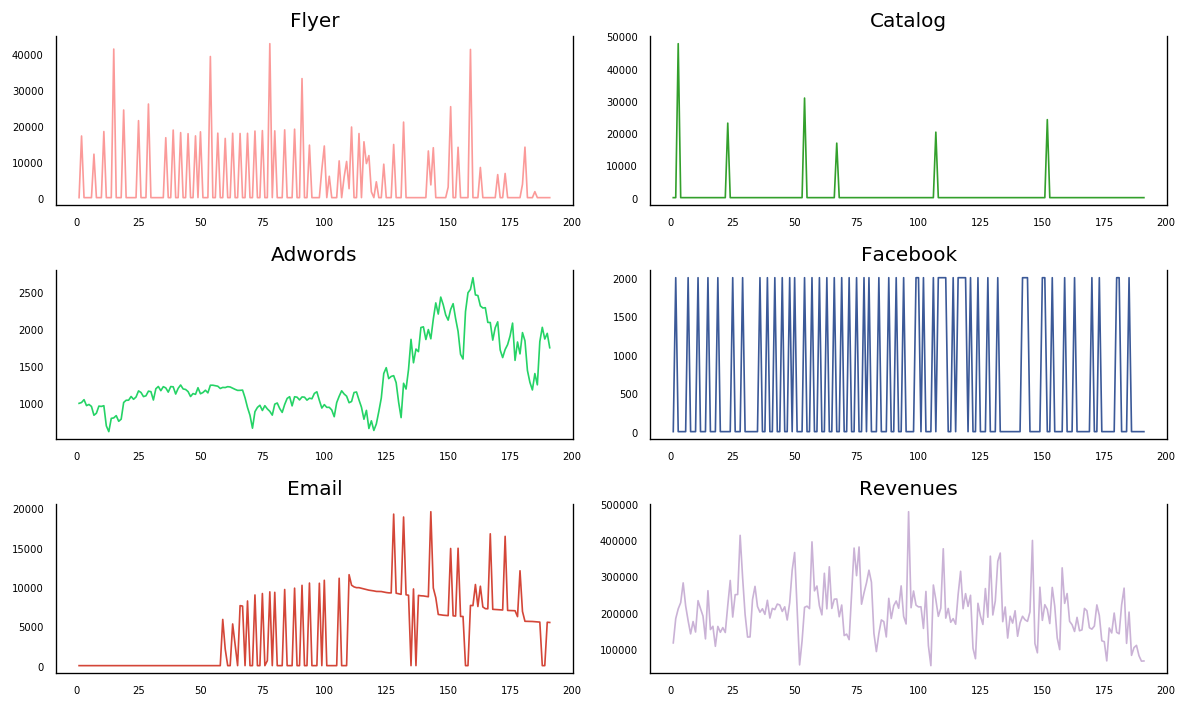

In [6]:
# Plotting each time series in the dataset
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    colors = ['#fb9a99', '#33a02c', '#25D366', '#3b5998', '#D44638', '#cab2d6']
    data = df[df.columns[i]]
    ax.plot(data, linewidth=1, color = colors[i])
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout() 

## Vector AutoRegression (VAR)
The basis behind Vector AutoRegression is that each of the time series in the system influences each other. That is, you can predict the series with past values of itself along with other series in the system.

### Testing Causation using Granger’s Causality Test
Using Granger’s Causality Test, it’s possible to test this relationship before even building the model. Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero.

In simpler terms, the past values of time series (X) do not cause the other series (Y). So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis.

In [7]:
## Creating a function for testing and visualising Grangers Causation Matrix
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            #if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In the matrix, the rows are the response (Y) and the columns are the predictor series (X). For example, if you take the value 0.0194 in (row 1, column 2), it refers to the p-value of Catalog_x causing Flyer_y. Whereas, the 0.0624 in (row 2, column 1) refers to the p-value of Catalog_y causing Flyer_x. In this matrix if the given p-value is less than the selected significance level (0.05) the the corresponding X columns (series) is said to cause the the Y row. If the p-value < 0.05 than, like is the case for Catalog_x and Flyer_y (0.0194 < 0.05), the null hypotheses can be reject and it is concluded that Catalog_x causes Flyer_y. Out of the 25 possible p-values, 13 are less than 0.05 and therefore 13 variables he system are interchangeably causing each other. This makes this series a good candidate for a VAR model analysis. 

In [8]:
## Grangers Caustation Matrix for the dataset
grangers_causation_matrix(df, variables = df.columns)    

,Flyer_x,Catalog_x,Adwords_x,Facebook_x,Email_x,Revenues_x
Flyer_y,1.0000,0.0194,0.0362,0.0478,0.0222,0.0529
Catalog_y,0.0624,1.0000,0.7560,0.0603,0.0662,0.0191
Adwords_y,0.0420,0.1158,1.0000,0.0074,0.0103,0.0503
Facebook_y,0.0031,0.3191,0.0501,1.0000,0.1725,0.2888
Email_y,0.0001,0.2409,0.0004,0.0031,1.0000,0.2479
Revenues_y,0.0333,0.0639,0.0236,0.0442,0.5129,1.0000


### Cointegration Test
Cointegration is a statistical property of a collection of time series variables. First, all of the series must be integrated of order d. Next, if a linear combination of this collection is integrated of order less than d, then the collection is said to be co-integrated.

Now, when you have two or more time series, and there exists a linear combination of them that has an order of integration (d) less than that of the individual series, then the collection of series is said to be cointegrated. When two or more time series are cointegrated, it means they have a long run, statistically significant relationship. 

In [9]:
## Function for the Cointegration Test
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.9':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(90%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

Three out of the six time series seem to establish a long run, statistically significant relationship.

In [10]:
## Testing for Cointegration
cointegration_test(df, alpha = 0.1)

Name   ::  Test Stat > C(90%)    =>   Signif  
 ----------------------------------------
Flyer  ::  129.86    > 79.5329   =>   True
Catalog ::  77.96     > 56.2839   =>   True
Adwords ::  38.95     > 37.0339   =>   True
Facebook ::  12.28     > 21.7781   =>   False
Email  ::  3.6       > 10.4741   =>   False
Revenues ::  0.04      > 2.9762    =>   False


### Checking and Making the Time Series Stationary
The Vector AutoRegressive model requires the data to be stationary. This implies that the process has the property that the mean, variance and autocorrelation structure do not change over time. We did a visual test through the inital plots and all variables did not look very stationary. Here we will try to confirm our hypothesis by using popular statistical tests to evaluate it.

In [11]:
## Function for Adfuller Test on data
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

Only the Flyer, Catalog and Revenue time series are stationary. This confirms our hypothesis and will require us to transform the data in order to make it stationary before continuing our analysis.

In [12]:
# ADF Test on each column
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Flyer" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.6991
 No. Lags Chosen       = 5
 Critical value 1%     = -3.466
 Critical value 5%     = -2.877
 Critical value 10%    = -2.575
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Catalog" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -14.1082
 No. Lags Chosen       = 0
 Critical value 1%     = -3.465
 Critical value 5%     = -2.877
 Critical value 10%    = -2.575
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Adwords" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level

### Differecing 
Differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) trend and seasonality. This is what we are trying to do. This is simple to do with Python as we can call the Pandas dataframe.diff() method.

In [13]:
## First-Order difference applied to time series
df_differenced = df.diff().dropna()
df_log = np.log(df_differenced)
df_log = df_log.replace([np.inf, -np.inf, np.nan], 0)
df_log

,Flyer,Catalog,Adwords,Facebook,Email,Revenues
Week,,,,,,
2,9.748832,0.000000,2.445386,7.600902,0.000000,11.118358
3,0.000000,10.773277,3.641919,0.000000,0.000000,10.200550
4,0.000000,0.000000,0.000000,0.000000,0.000000,9.757594
5,0.000000,0.000000,2.726545,0.000000,0.000000,10.909665
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
187,0.000000,0.000000,6.365215,0.000000,0.000000,9.976178
188,0.000000,0.000000,5.258432,0.000000,0.000000,8.727650
189,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [14]:
## Retesting the dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Flyer" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.5197
 No. Lags Chosen       = 10
 Critical value 1%     = -3.467
 Critical value 5%     = -2.878
 Critical value 10%    = -2.575
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Catalog" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.4362
 No. Lags Chosen       = 11
 Critical value 1%     = -3.468
 Critical value 5%     = -2.878
 Critical value 10%    = -2.576
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Adwords" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level  

### Selecting the Order (P) of VAR Model
To select the right order of the VAR model, we iteratively fit increasing orders of VAR model and pick the order that gives a model with least AIC. Though the usual practice is to look at the AIC, we can also check other best fit comparison estimates of BIC, FPE and HQIC.

In [15]:
## Optimising for the lowest information criteria over various lag orders
model = VAR(df_log)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  11.73364643759979
BIC :  12.4540346631686
FPE :  124722.90879691519
HQIC:  12.025493034305622 

Lag Order = 2
AIC :  11.560730152028908
BIC :  12.903509264266866
FPE :  105035.79993594564
HQIC:  12.104773723643087 

Lag Order = 3
AIC :  11.78344050277478
BIC :  13.753207253156722
FPE :  131618.42585845877
HQIC:  12.581590748975714 

Lag Order = 4
AIC :  11.830531517951592
BIC :  14.431940125784818
FPE :  138739.16009215193
HQIC:  12.884721343275793 

Lag Order = 5
AIC :  12.059428549596365
BIC :  15.297191703458896
FPE :  176058.66994106912
HQIC:  13.371614443054794 

Lag Order = 6
AIC :  12.16356557838142
BIC :  16.042455459844433
FPE :  198174.41158943204
HQIC:  13.735728000691095 

Lag Order = 7
AIC :  12.270492527246102
BIC :  16.795341857481546
FPE :  225072.05088405233
HQIC:  14.104636305850931 

Lag Order = 8
AIC :  12.406076342103006
BIC :  17.58177945199629
FPE :  265061.88476866944
HQIC:  14.504231074161936 

Lag Order = 9
AIC :  12.507615147708218
BIC : 

An alternate method to choose the order(p) of the VAR models is to use the model.select_order(maxlags) method. The selected order(p) is the order that gives the lowest ‘AIC’, ‘BIC’, ‘FPE’ and ‘HQIC’ scores.

In [16]:
## A more visual option
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,11.83,11.94*,1.379e+05,11.88*
1,11.72,12.47,1.228e+05,12.02
2,11.71*,13.10,1.218e+05*,12.27
3,11.92,13.96,1.508e+05,12.74
4,12.00,14.68,1.643e+05,13.09
5,12.21,15.53,2.043e+05,13.55
6,12.33,16.30,2.344e+05,13.94
7,12.42,17.03,2.614e+05,14.29
8,12.52,17.78,3.001e+05,14.66
9,12.62,18.52,3.428e+05,15.01


In [17]:
## Fittin for Lag 3
model_fitted = model.fit(2)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 17, Apr, 2020
Time:                     10:57:54
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    12.9035
Nobs:                     188.000    HQIC:                   12.1048
Log likelihood:          -2609.27    FPE:                    105036.
AIC:                      11.5607    Det(Omega_mle):         70324.7
--------------------------------------------------------------------
Results for equation Flyer
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               4.941316         0.724883            6.817           0.000
L1.Flyer           -0.356671         0.171496           -2.080           0.038
L1.Catalog         -0.031973         0.167777           -0.191      

### Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
Serial correlation of residuals is used to check if there is any leftover pattern in the residuals (errors). If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system or look for a different algorithm to model the time series.

The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

These residuals are all extremely close to 2 and therefore it can be concluded that no significant serial correlation is present. 

In [18]:
## Checking Durbin Watson statistic
from statsmodels.stats.stattools import durbin_watson
durbin_watson(model_fitted.resid)

array([2.0000927 , 2.00262215, 2.01325424, 2.02742121, 2.05868175,
       2.05008203])

### Checking the Residuals
After the estimation it is always good to check the residuals’ normality and the autocorrelation. If there is any misspecification, you may need to search if any anomaly such as outlier and structural break occurs.

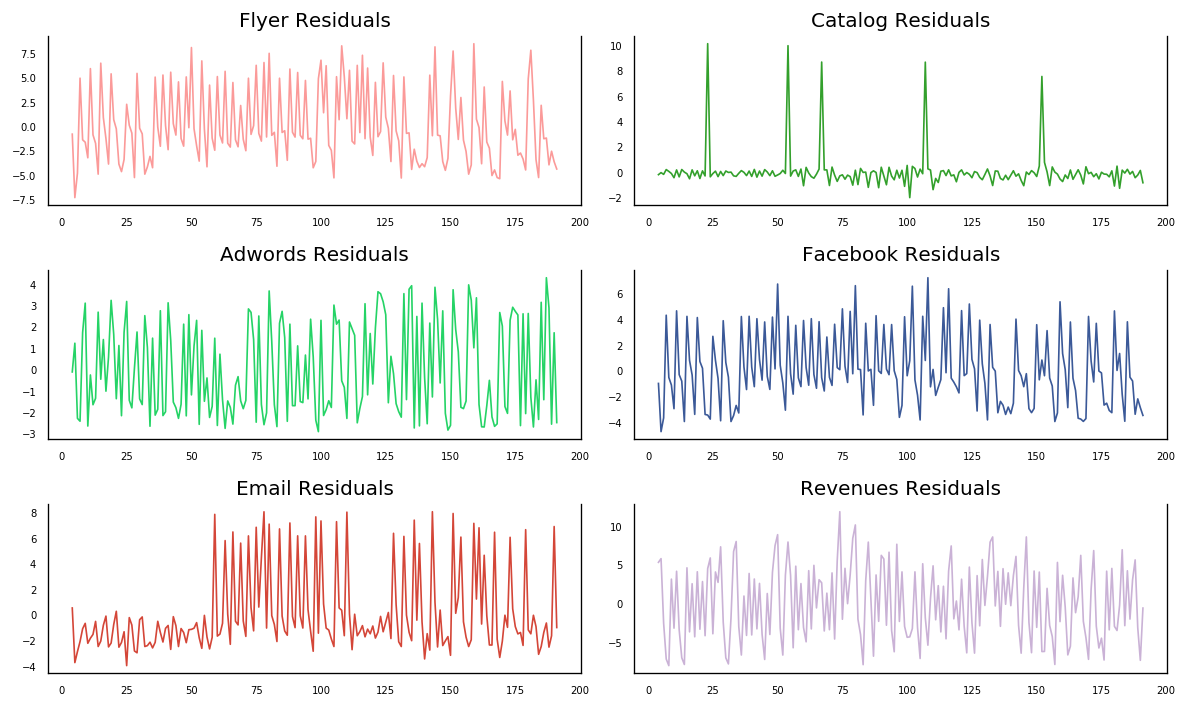

In [19]:
# Plotting each time series in the dataset
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    colors = ['#fb9a99', '#33a02c', '#25D366', '#3b5998', '#D44638', '#cab2d6']
    out = model_fitted.resid
    data = out[df_differenced.columns[i]]
    ax.plot(data, color=colors[i], linewidth=1)
    # Decorations
    ax.set_title(df.columns[i] + ' Residuals')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

## Initial Response Analysis
Impulse response analysis is an important step in econometric analyes, which employ vector autoregressive models. Their main purpose is to describe the evolution of a model’s variables in reaction to a shock in one or more variables. This feature allows to trace the transmission of a single shock within an otherwise noisy system of equations and, thus, makes them very useful tools in the assessment of economic policies.

We will use the initial response to get a better picture of the model’s dynamic behaviour.

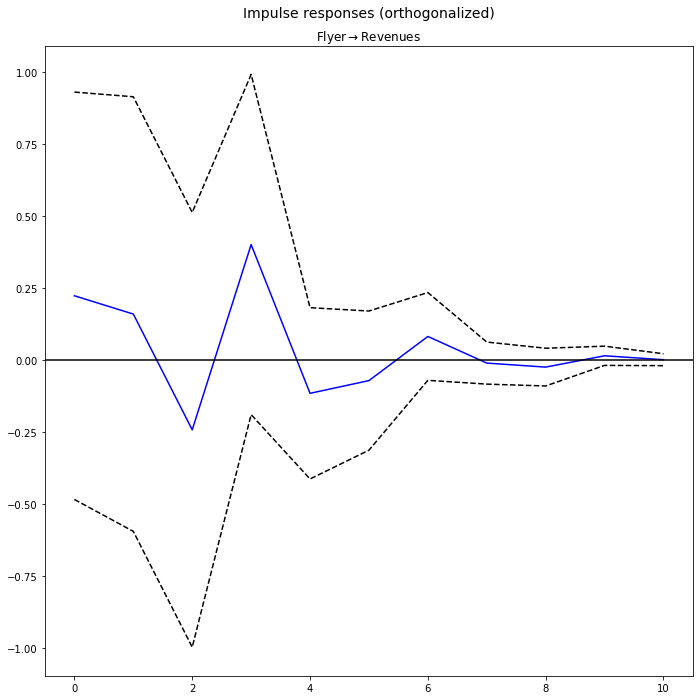

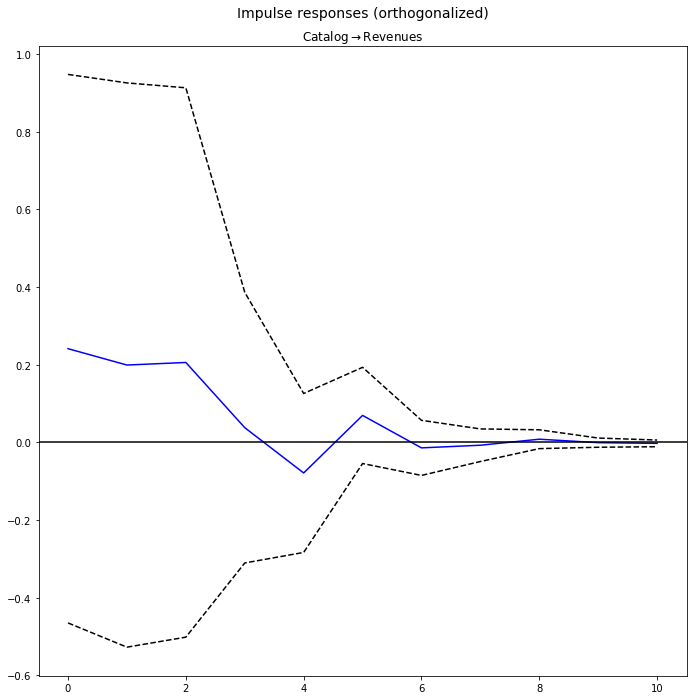

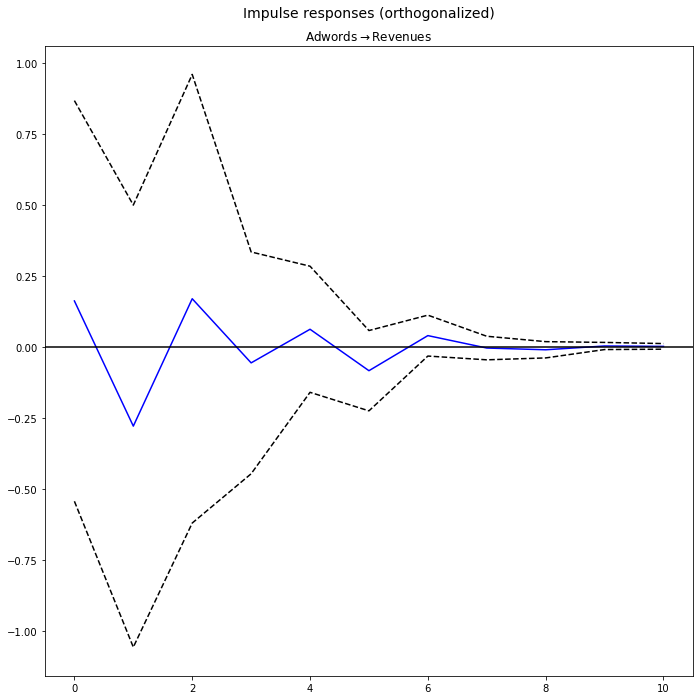

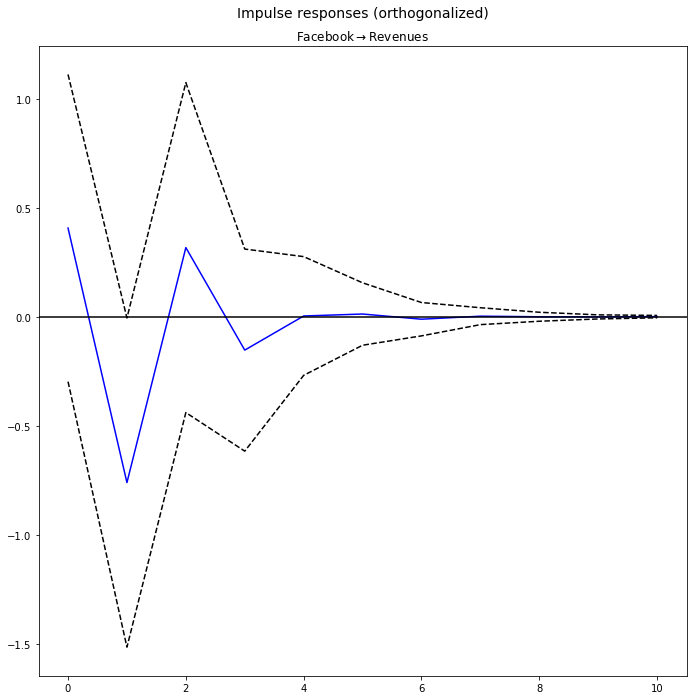

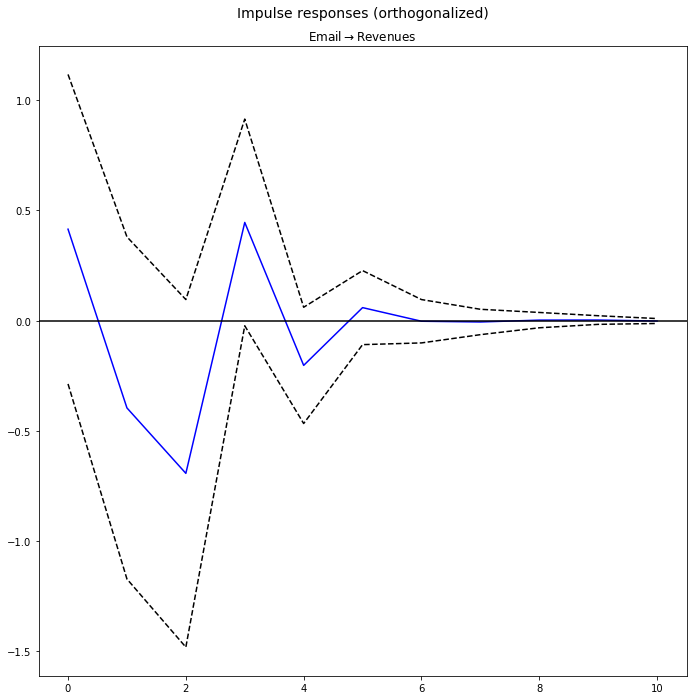

In [20]:
## Plotting Initial Response
import statsmodels.tsa.vector_ar.irf as ira
iras = ira.IRAnalysis(model_fitted)
flyer_ira = iras.plot(impulse = 'Flyer', response = 'Revenues', signif = 0.05, repl = 1000, orth = True) 
catalog_ira = iras.plot(impulse = 'Catalog', response = 'Revenues', signif = 0.05, repl = 1000, orth = True)
adwords_ira = iras.plot(impulse = 'Adwords', response = 'Revenues', signif = 0.05, repl = 1000, orth = True)
facebook_ira = iras.plot(impulse = 'Facebook', response = 'Revenues', signif = 0.05, repl = 1000, orth = True)
email_ira = iras.plot(impulse = 'Email', response = 'Revenues', signif = 0.05, repl = 1000, orth = True)

### Statistically Significant IRF Coefficients
A dataframe containing IRF coefficients and their confidence intervals may be created for further analysis

In [21]:
## Finding the IRF Values
plots = [flyer_ira, catalog_ira, adwords_ira, facebook_ira, email_ira]

campaigns = dict()

for plot in plots:
    ax = plot.gca()
    line = ax.lines[0]
    list1 = []
    for value in line.get_ydata():
        list1.append(value)
    campaigns[plot] = list1

In [22]:
## Creating DataFrame from campaings
df_irf = pd.DataFrame(campaigns)
df_irf.columns = ['flyer', 'catalog', 'adwords', 'facebook', 'email']
df_irf

,flyer,catalog,adwords,facebook,email
0,0.223619,0.241520,0.162224,0.406568,0.414180
1,0.160147,0.199412,-0.278647,-0.760418,-0.396367
2,-0.241655,0.206009,0.170004,0.316975,-0.693139
3,0.401477,0.038152,-0.055882,-0.153070,0.444800
4,-0.115006,-0.078482,0.062495,0.003369,-0.203493
5,-0.070825,0.069651,-0.083449,0.012343,0.058486
6,0.082442,-0.013903,0.040168,-0.011391,-0.003283
7,-0.010044,-0.007079,-0.003642,0.002494,-0.006606
8,-0.023994,0.008409,-0.009776,-0.000153,0.001792
9,0.015308,-0.000450,0.003600,-0.000870,0.002150


Now we apply the t > 1 criteria to determine coefficient significance and calculate long-term elasticities of adwords and flyer advertising spending. If the t-statistics of the IRF coefficient is greater than 1 (t > 1) then, those values are treated as significant and are kept in the dataframe. If the t-statistic is less than 1, the value is replaced by 0 in the dataframe.

In [23]:
## Replace values that are less than 0.01 with 0 
for col in df_irf.columns:
    df_irf[col].loc[(df_irf[col]) < 0.01] = 0

df_irf

,flyer,catalog,adwords,facebook,email
0,0.223619,0.241520,0.162224,0.406568,0.414180
1,0.160147,0.199412,0.000000,0.000000,0.000000
2,0.000000,0.206009,0.170004,0.316975,0.000000
3,0.401477,0.038152,0.000000,0.000000,0.444800
4,0.000000,0.000000,0.062495,0.000000,0.000000
5,0.000000,0.069651,0.000000,0.012343,0.058486
6,0.082442,0.000000,0.040168,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.015308,0.000000,0.000000,0.000000,0.000000


## Optimal Budget Allocation
The t-statistics now for part of the calculation needed to find the long term and short term affects of the respective advertising campaign. The goal of this paper is to help the company review their current marketing budget allocation and explore a new combination of vhannel budget split values so as to optimally allocate their resources. 

In [24]:
## Function to sum significant coefficients overtime to get the long-term elasticities
def long_term_elas(df_col):
    return df_col.sum()

In [25]:
## Finding long-term elasticities of each channel
lt_flyer = long_term_elas(df_irf['flyer'])
lt_catalog = long_term_elas(df_irf['catalog'])
lt_adwords = long_term_elas(df_irf['adwords'])
lt_facebook = long_term_elas(df_irf['facebook'])
lt_email = long_term_elas(df_irf['email'])
lt_total = lt_flyer + lt_catalog + lt_adwords + lt_facebook + lt_email

In [26]:
total_flyer = df['Flyer'].sum()
total_catalog = df['Catalog'].sum()
total_adwords = df['Adwords'].sum()
total_facebook = df['Facebook'].sum()
total_email = df['Email'].sum()
total_all = total_flyer + total_catalog + total_adwords + total_facebook + total_email

### Current Budget
The budget will be visualised to represent the current split before the paper proceeds to calculate and visualise the optimal split. This visualisation displays the percentage of marketing $$$ that are allocated to each marketing channel at the time of investigation. 

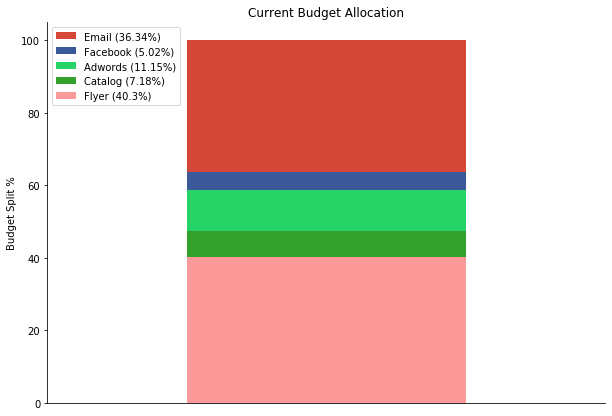

In [27]:
## Plotting % stacked chart
raw_data = {'Flyer (40.3%)': [total_flyer / total_all * 100], 'Catalog (7.18%)': [total_catalog / total_all * 100],
            'Adwords (11.15%)': [total_adwords / total_all * 100], 'Facebook (5.02%)' : [total_facebook / total_all * 100], 
            'Email (36.34%)' : [total_email / total_all * 100]}
df_bl = pd.DataFrame(raw_data)

colors = ['#fb9a99', '#33a02c', '#25D366', '#3b5998', '#D44638']

ax = df_bl.loc[:,['Flyer (40.3%)','Catalog (7.18%)', 'Adwords (11.15%)', 
                  'Facebook (5.02%)', 'Email (36.34%)']].plot.bar(stacked=True, figsize=(10,7), color=colors)
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.legend(facecolor = 'white')
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='upper left', facecolor = 'white') 
plt.xticks([])
plt.ylabel('Budget Split %')
plt.title('Current Budget Allocation')
handles, labels = ax.get_legend_handles_labels()
plt.show()

### Optimal Budget Allocation from IRF Analysis
For the optimal marketing budget allocation, we need to retrieve the impact of the channels spending from IRF analysis. More specifically, we will calculate the optimal allocation for each marketing channel using the following formula:

In [28]:
## Creat a fucntion that is able to find the optimal allocation based on the optimal allocation formula
def optimal_allocation(channel_irf):
    return channel_irf / lt_total

In [29]:
## Apply the function to all marketing channels 
optim_flyers = optimal_allocation(lt_flyer)
optim_catalog = optimal_allocation(lt_catalog)
optim_adwords = optimal_allocation(lt_adwords)
optim_facebook = optimal_allocation(lt_facebook)
optim_email = optimal_allocation(lt_email)

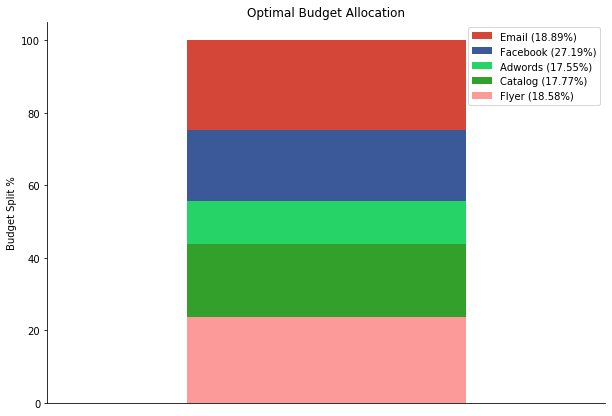

In [30]:
## Plot
raw_data = {'Flyer (18.58%)': [optim_flyers * 100], 'Catalog (17.77%)': [optim_catalog * 100],
            'Adwords (17.55%)': [optim_adwords * 100], 'Facebook (27.19%)' : [optim_facebook * 100], 
            'Email (18.89%)' : [optim_email * 100]}
df_bl = pd.DataFrame(raw_data)

colors = ['#fb9a99', '#33a02c', '#25D366', '#3b5998', '#D44638']

ax = df_bl.loc[:,['Flyer (18.58%)','Catalog (17.77%)', 'Adwords (17.55%)', 
                  'Facebook (27.19%)', 'Email (18.89%)']].plot.bar(stacked=True, figsize=(10,7), color=colors)
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.legend(facecolor = 'white')
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='upper right', facecolor = 'white') 
plt.xticks([])
plt.ylabel('Budget Split %')
plt.title('Optimal Budget Allocation')
handles, labels = ax.get_legend_handles_labels()
plt.show()

## Conclusion
The visualization reveals that the current budget split is essentially not optimal. It is clear that the retailer is under-estimating the power of online marketing through Adwords, Facebook and over-emphasizing the importance of the offline Flyer channel and hard to track Email. The optimal resource allocation finds a more holistic and even split of the budget in contrast the retailer’s current allocation. This makes sense as a rounded split may reach a far wider demographic than a singular focus on one channel like is currently done.

Finding the optimal marketing resource allocation is a challenging process that requires due diligence and understanding of various statistics and econometrics phenomenon. It is a process that decision makes must take seriously as it is critical to a company’s success. This paper has demonstrated how optimizing for a constrained resource can positively impact firm performance by finding utilizing a VAR model on constraints (channel budgets) in order to derive the long-term elasticity of the variables. 
As weeks go on and marketing dollars spent, the decision makers must reevaluate this new optimal allocation especially if new channels are introduced. 

The next steps would be to further investigate each  individual channel. For Adwords and Facebook conversion tracking are essential to measuring and quantifying the potential success of the channels. The channels attribution can be optimized through Markov Chains which would allow to statistically model a user’s journey and visualize their conversion path. This would enhance the report we have completed here because we would identify the statistical impact the online channel would have on conversions and revenues.

## Further Reading
#### Vector Autoregression (VAR)
https://www.econometrics-with-r.org/16-1-vector-autoregressions.html  
https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/  

#### Cointegration Test
https://corporatefinanceinstitute.com/resources/knowledge/other/cointegration/

#### Durbin-Watson Statistic
https://www.statisticshowto.com/durbin-watson-test-coefficient/  
https://www.investopedia.com/terms/d/durbin-watson-statistic.  
 
#### Impulse Response Analysis (IRF) Analysis 
https://en.wikipedia.org/wiki/Impulse_response